<a href="https://colab.research.google.com/github/bibekebib/Nepali-Letters-and-Numbers-classification-generation/blob/main/Nepali_handwriting_(Numbers)_Prediction_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import tqdm
import cv2
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as T

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!git clone https://github.com/kcnishan/Nepali_handwritten_digits_recognition.git

Cloning into 'Nepali_handwritten_digits_recognition'...
remote: Enumerating objects: 92087, done.
remote: Total 92087 (delta 0), reused 0 (delta 0), pack-reused 92087
Receiving objects: 100% (92087/92087), 67.09 MiB | 22.08 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (92306/92306), done.


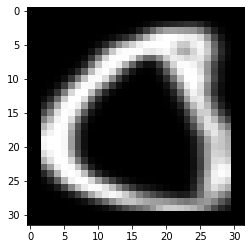

In [ ]:
plt.imshow(cv2.imread('/content/Nepali_handwritten_digits_recognition/dataset/Test/digits/digit_0/103277.png'))

In [ ]:
X_img = []
train_path = '/content/Nepali_handwritten_digits_recognition/dataset/Train/digits'
Test_path = '/content/Nepali_handwritten_digits_recognition/dataset/Test/digits'
for each in os.listdir('/content/Nepali_handwritten_digits_recognition/dataset/Train/digits'):
  print(each)
  for x in os.listdir(train_path+'/'+each):
    X_img.append([train_path+'/'+each+'/'+x, each])
    break

digit_9
digit_5
digit_7
digit_0
digit_4
digit_3
digit_6
digit_2
digit_8
digit_1


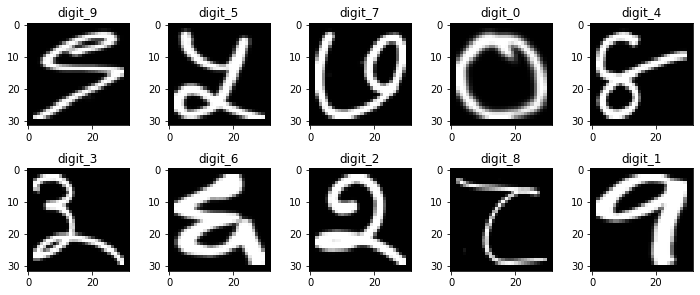

In [ ]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(10):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    img = cv2.imread(X_img[i][0])
    plt.imshow(img)
    plt.title(X_img[i][1])
    plt.tight_layout(pad=1.0)
plt.show()

In [ ]:
img_path = []
label = []
for each in os.listdir(train_path):
  for x in os.listdir(train_path+'/'+each):
    img_path.append(train_path+'/'+each+'/'+x)
    label.append(each)

In [ ]:
img_path_test = []
label_test = []
for each in os.listdir(Test_path):
  for x in os.listdir(Test_path+'/'+each):
    img_path_test.append(Test_path+'/'+each+'/'+x)
    label_test.append(each)

In [ ]:
df = pd.DataFrame(list(zip(img_path, label)), columns=['path', 'label'])

In [ ]:
df_test = pd.DataFrame(list(zip(img_path_test, label_test)), columns=['path', 'label'])

In [ ]:
df.head()

,path,label
0,/content/Nepali_handwritten_digits_recognition...,digit_9
1,/content/Nepali_handwritten_digits_recognition...,digit_9
2,/content/Nepali_handwritten_digits_recognition...,digit_9
3,/content/Nepali_handwritten_digits_recognition...,digit_9
4,/content/Nepali_handwritten_digits_recognition...,digit_9


In [ ]:
df_test.head()

,path,label
0,/content/Nepali_handwritten_digits_recognition...,digit_9
1,/content/Nepali_handwritten_digits_recognition...,digit_9
2,/content/Nepali_handwritten_digits_recognition...,digit_9
3,/content/Nepali_handwritten_digits_recognition...,digit_9
4,/content/Nepali_handwritten_digits_recognition...,digit_9


In [ ]:
cv2.imread(df.path[0]).shape

(32, 32, 3)

In [ ]:
LbE = LabelEncoder()
df.label =  LbE.fit_transform(df.label)
df_test.label =  LbE.fit_transform(df_test.label)

In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test

,path,label
0,/content/Nepali_handwritten_digits_recognition...,7
1,/content/Nepali_handwritten_digits_recognition...,3
2,/content/Nepali_handwritten_digits_recognition...,5
3,/content/Nepali_handwritten_digits_recognition...,2
4,/content/Nepali_handwritten_digits_recognition...,0
...,...,...
2995,/content/Nepali_handwritten_digits_recognition...,9
2996,/content/Nepali_handwritten_digits_recognition...,8
2997,/content/Nepali_handwritten_digits_recognition...,0
2998,/content/Nepali_handwritten_digits_recognition...,9


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df

,path,label
0,/content/Nepali_handwritten_digits_recognition...,2
1,/content/Nepali_handwritten_digits_recognition...,0
2,/content/Nepali_handwritten_digits_recognition...,8
3,/content/Nepali_handwritten_digits_recognition...,4
4,/content/Nepali_handwritten_digits_recognition...,7
...,...,...
16995,/content/Nepali_handwritten_digits_recognition...,9
16996,/content/Nepali_handwritten_digits_recognition...,3
16997,/content/Nepali_handwritten_digits_recognition...,1
16998,/content/Nepali_handwritten_digits_recognition...,9


In [ ]:
class LetterDataset(Dataset):
  def __init__(self, df):
    self.fpath = df.path
    self.label = df.label
    self.transform = T.Compose(
   [T.ToPILImage(),
    T.ToTensor(),  
    T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   ),
    T.Grayscale(num_output_channels=1)
    ]
)

  def __len__(self):
    return len(self.fpath)
  
  def __getitem__(self, ix):
    img = self.fpath[ix]
    target = self.label[ix]
    img = cv2.imread(img)
    im = self.transform(img)
    return torch.tensor(im/255).to(device).float(), torch.tensor(target).long().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([1, 32, 32])


Text(0.5, 1.0, "tensor(0, device='cuda:0')")

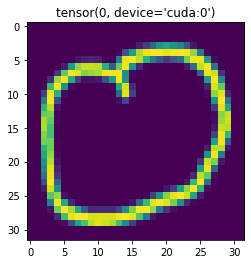

In [ ]:
data =  LetterDataset(df)
img, label = data[100]
print(img.shape)
plt.imshow(img.cpu().reshape(32,32))
plt.title(label)

In [ ]:
def conv_layer(ni, no, kernel_size, max_pool_num=2, stride=1,):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.BatchNorm2d(no),
      nn.LeakyReLU(0.2),
      nn.MaxPool2d(max_pool_num)
  )

In [ ]:
from torch.nn.modules.activation import Softmax
def get_model():
  model = nn.Sequential(
      conv_layer(1,8,2),
      conv_layer(8,16, 2),
      conv_layer(16, 64, 2),
      nn.Flatten(),
      nn.Linear(64*3*3,192),
      nn.ReLU(),
      nn.Linear(192, 64),
      nn.ReLU(),
      nn.Linear(64, 10),
      nn.Softmax()
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [ ]:
def calculateHWOUT(H_in, W_IN, padding, kernel_size, stride, max_pool_num):
    H_out = (((H_in + 2*padding - kernel_size) / stride ) +1) / max_pool_num
    W_out = (((W_IN + 2*padding - kernel_size) / stride ) +1) / max_pool_num
    return (round(H_out), round(W_out))

In [ ]:
calculateHWOUT(H_in=4, W_IN=4, padding=0, kernel_size=2, stride=1, max_pool_num=2)

(2, 2)

In [ ]:
model, loss_fn, optimizer = get_model()

In [ ]:
from torchsummary import summary
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 31, 31]              40
       BatchNorm2d-2            [-1, 8, 31, 31]              16
         LeakyReLU-3            [-1, 8, 31, 31]               0
         MaxPool2d-4            [-1, 8, 15, 15]               0
            Conv2d-5           [-1, 16, 14, 14]             528
       BatchNorm2d-6           [-1, 16, 14, 14]              32
         LeakyReLU-7           [-1, 16, 14, 14]               0
         MaxPool2d-8             [-1, 16, 7, 7]               0
            Conv2d-9             [-1, 64, 6, 6]           4,160
      BatchNorm2d-10             [-1, 64, 6, 6]             128
        LeakyReLU-11             [-1, 64, 6, 6]               0
        MaxPool2d-12             [-1, 64, 3, 3]               0
          Flatten-13                  [-1, 576]               0
           Linear-14                  [

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
def get_data():
  data =  LetterDataset(df)
  trn_ldr = DataLoader(data, batch_size=32, shuffle=True)
  data_test = LetterDataset(df_test)
  test_ldr = DataLoader(data_test, batch_size=32, shuffle=True)
  return trn_ldr, test_ldr

In [ ]:
def train_batch(x, y, model, loss_fn, optimizer):
  model.train()
  pred = model(x)
  batch_loss = loss_fn(pred, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  pred = model(x)
  _, is_correct = torch.max(pred.data,1)
  acc_all = (is_correct==y).detach().cpu().numpy()
  return acc_all

In [ ]:
@torch.no_grad()
def val_loss_trn(x, y, model, loss_fn):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)

  return val_loss.item()

In [ ]:
trn_ldr, test_ldr = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_loss = []
train_accuracies= []
val_loss = [] 
val_accuracies = []

for i in range(20):
  print(f'Epoch: _________*****{i}*****_______')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies, val_epoch_losses = [], []



  for ix, batch in (enumerate(iter(trn_ldr))):
      x, y = batch
      train_epoch_losses.append(train_batch(x, y, model, loss_fn, optimizer))
  train_epoch_loss = np.array(train_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Training Loss : {train_epoch_loss} *****_______')



  for ix, batch in (enumerate(iter(trn_ldr))):
    x, y = batch
    train_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  train_epoch_accuracy = np.array(train_epoch_accuracies).mean()
  print(f'Epoch: _________*****{i} Training Accuracy: {train_epoch_accuracy} *****_______')



  for ix, batch in (enumerate(iter(test_ldr))):
    x, y = batch
    val_epoch_losses.append(val_loss_trn(x, y, model, loss_fn))
  val_epoch_loss = np.array(val_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Validation Loss : {val_epoch_loss} *****_______')

  for ix, batch in (enumerate(iter(test_ldr))):
    x, y = batch
    val_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  print(f'Epoch: _________*****{i} Validation Accuracy. {val_epoch_accuracy} *****_______')
  val_epoch_accuracy = np.array(val_epoch_accuracies).mean()
  print('\n')

  train_loss.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  val_loss.append(val_epoch_loss)

Epoch: _________*****0*****_______


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: _________*****0 Training Loss : 1.467172447227894 *****_______
Epoch: _________*****0 Training Accuracy: 0.9987077067669173 *****_______
Epoch: _________*****0 Validation Loss : 1.4689860305887588 *****_______
Epoch: _________*****0 Validation Accuracy. 0.9940159574468085 *****_______


Epoch: _________*****1*****_______
Epoch: _________*****1 Training Loss : 1.4630428980615802 *****_______
Epoch: _________*****1 Training Accuracy: 0.9971804511278195 *****_______
Epoch: _________*****1 Validation Loss : 1.4708235454052052 *****_______
Epoch: _________*****1 Validation Accuracy. 0.9920212765957447 *****_______


Epoch: _________*****2*****_______
Epoch: _________*****2 Training Loss : 1.464478238856882 *****_______
Epoch: _________*****2 Training Accuracy: 0.864250469924812 *****_______
Epoch: _________*****2 Validation Loss : 1.5931803660189852 *****_______
Epoch: _________*****2 Validation Accuracy. 0.9902482269503545 *****_______


Epoch: _________*****3*****_______
Epoch: ___

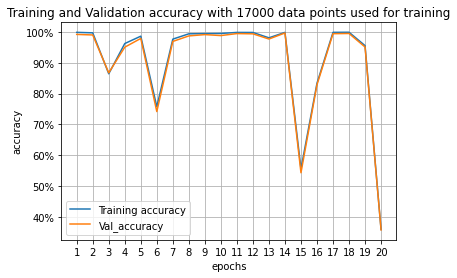

In [ ]:
epochs = np.arange(20) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_accuracies , label='Training accuracy')
plt.plot(epochs, val_accuracies, label='Val_accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation accuracy with 17000 data points used for training')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()

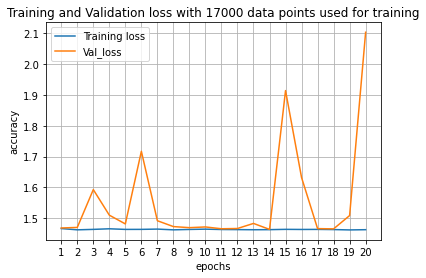

In [ ]:
epochs = np.arange(20) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_loss , label='Training loss')
plt.plot(epochs, val_loss, label='Val_loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation loss with 17000 data points used for training')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in plt.gca().get_yticks()])/
plt.grid('off')
plt.show()

In [ ]:
def preprocess_predict_data(img_path):
  img = cv2.imread(img_path)
  transform = T.Compose(
   [T.ToPILImage(),
    T.ToTensor(),  
    T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   ),
    T.Grayscale(num_output_channels=1)
    ]
  )
  img = transform(img).to(device)
  return img

def predict(x, model):
  img = preprocess_predict_data(x)
  img = img.unsqueeze_(0)
  pred = model(img)
  return torch.max(pred.data, 1)

In [ ]:
img_path = '/content/Nepali_handwritten_digits_recognition/dataset/Test/digits/digit_4/40846.png'
# img = preprocess_predict_data(img_path)
pred = predict(img_path, model)
pred

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.return_types.max(
values=tensor([1.], device='cuda:0'),
indices=tensor([4], device='cuda:0'))

In [ ]:
img_path = '/content/Nepali_handwritten_digits_recognition/dataset/Test/digits/digit_7/10215.png'
pred = predict(img_path, model)
pred

torch.return_types.max(
values=tensor([1.], device='cuda:0'),
indices=tensor([7], device='cuda:0'))